In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
%matplotlib inline
sns.set_style(style='whitegrid')

In [3]:
from keys import keys
from binance.client import Client

In [4]:
client = Client(api_key=keys.apiKey, api_secret=keys.secretKey)

In [5]:
"""
The various columns used by Binance
taken from:
https://python-binance.readthedocs.io/en/latest/binance.html#module-binance.client
"""

columns = ['Open Time', 'Open', 'High', 'Low', 'Close',
            'Volume', 'Close Time', 'Quote asset volume', 
            'n_trades', 'Taker buy base asset volume', 
            'Taker buy quote asset volume', 'Ignore']

In [52]:
"""
DOWNLOADS DATA FROM BINANCE IN BATCHES OF 500 items

INPUTS:
    n_iterations: how many batches of 500 items to download
    
    currency: one of the varios currencies, examples: 
                'BTCUSDT', 'LTCUSDT' ...etc
    interval: dictionary, example: interval_5min = { 
                                        'interval' : Client.KLINE_INTERVAL_5MINUTE,
                                        'interval_diff' : 300000 
                                    }
            interval_diff: the difference in millisec of of new_data[1][0] - new_data[0][0]
            (the difference in binance timeframes of misurations)
"""
def get_by_intervals(n_iterations, currencies, interval):
    main_df = pd.DataFrame()
    
    for currency in currencies:
        currency_cols = []
        for col in columns:
            currency_cols.append(currency+' '+col)
        
        df = pd.DataFrame(columns=currency_cols)
        
        for i in range(0,n_iterations):
            if df.empty:
                new_data = client.get_klines(symbol=currency, 
                                  interval=interval['interval'])
            else:
                end_time = df[currency+' Open Time'].iloc[0] - interval['interval_diff']
                new_data = client.get_klines(symbol=currency, 
                                  interval=interval['interval'],
                                  endTime=end_time
                                 )

            new_data_df = pd.DataFrame(new_data, columns=currency_cols)
            df = pd.concat([new_data_df,df])
    return df

In [49]:
"""
interval_diff: new_data[1][0] - new_data[0][0]
"""

interval_1min = { 'interval' : Client.KLINE_INTERVAL_1MINUTE,
                     'interval_diff': 60000 }

interval_5min = { 'interval' : Client.KLINE_INTERVAL_5MINUTE,
                    'interval_diff': 300000 }

interval_15min = { 'interval' : Client.KLINE_INTERVAL_15MINUTE,
                     'interval_diff': 900000 }

In [50]:
"""
USED TO TEST IF TIMESTAMPS ARE ALIGNED AND THERE ARE NO SUDDEN JUMPS

if it doesn't output anything we're good
"""

def test_time_skip(i_init,i_end,df):
    for i in range(i_init,i_end):
        if (df['Open Time'].iloc[i+1] - df['Open Time'].iloc[i] != 300000):
            print('FUUUCK',(df['Open Time'].iloc[i+1] - df['Open Time'].iloc[i]), 
                df['Open Time'].iloc[i+1], df['Open Time'].iloc[i],i)

In [53]:
ltc_test = get_by_intervals(2, ['LTCUSDT'], interval_5min)

In [54]:
ltc_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   LTCUSDT Open Time                     1000 non-null   object
 1   LTCUSDT Open                          1000 non-null   object
 2   LTCUSDT High                          1000 non-null   object
 3   LTCUSDT Low                           1000 non-null   object
 4   LTCUSDT Close                         1000 non-null   object
 5   LTCUSDT Volume                        1000 non-null   object
 6   LTCUSDT Close Time                    1000 non-null   object
 7   LTCUSDT Quote asset volume            1000 non-null   object
 8   LTCUSDT n_trades                      1000 non-null   object
 9   LTCUSDT Taker buy base asset volume   1000 non-null   object
 10  LTCUSDT Taker buy quote asset volume  1000 non-null   object
 11  LTCUSDT Ignore                 

In [11]:
ltc_test.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volume,n_trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,1580048100000,54.42000000,54.47000000,54.36000000,54.39000000,1308.98130000,1580048399999,71230.32895910,166,341.49777000,18582.98915770,0
1,1580048400000,54.39000000,54.62000000,54.35000000,54.55000000,806.34478000,1580048699999,43962.68083620,105,577.33158000,31474.15278590,0
2,1580048700000,54.55000000,54.56000000,54.49000000,54.51000000,361.03031000,1580048999999,19684.34364560,58,128.00276000,6980.62792340,0
3,1580049000000,54.51000000,54.77000000,54.50000000,54.74000000,1410.87464000,1580049299999,77152.63184950,223,972.98667000,53200.30126720,0
4,1580049300000,54.75000000,54.79000000,54.71000000,54.78000000,402.56782000,1580049599999,22042.49401700,88,254.70184000,13947.33184940,0


In [55]:
test_time_skip(0,999,ltc_test)

KeyError: 'Open Time'

In [13]:
ltc_test[['Open','Close', 'High','Low', 'Volume', 'Quote asset volume', 
            'Taker buy base asset volume', 'Taker buy quote asset volume'
           ]] = ltc_test[['Open','Close', 'High','Low', 'Volume', 'Quote asset volume', 
            'Taker buy base asset volume', 'Taker buy quote asset volume']].astype(float)

In [14]:
ltc_test['Close Time'] = ltc_test['Close Time'].apply(
    lambda x: datetime.fromtimestamp(int(x/1000)))
ltc_test['Open Time'] = ltc_test['Open Time'].apply(
    lambda x: datetime.fromtimestamp(int(x/1000)))

In [15]:
ltc_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open Time                     10000 non-null  datetime64[ns]
 1   Open                          10000 non-null  float64       
 2   High                          10000 non-null  float64       
 3   Low                           10000 non-null  float64       
 4   Close                         10000 non-null  float64       
 5   Volume                        10000 non-null  float64       
 6   Close Time                    10000 non-null  datetime64[ns]
 7   Quote asset volume            10000 non-null  float64       
 8   n_trades                      10000 non-null  object        
 9   Taker buy base asset volume   10000 non-null  float64       
 10  Taker buy quote asset volume  10000 non-null  float64       
 11  Ignore                        

In [16]:
print('Data timeframe:')
print( 'From:  ',ltc_test['Close Time'].max())
print( 'To     ',ltc_test['Close Time'].min())

Data timeframe:
From:   2020-03-01 15:24:59
To      2020-01-26 15:19:59


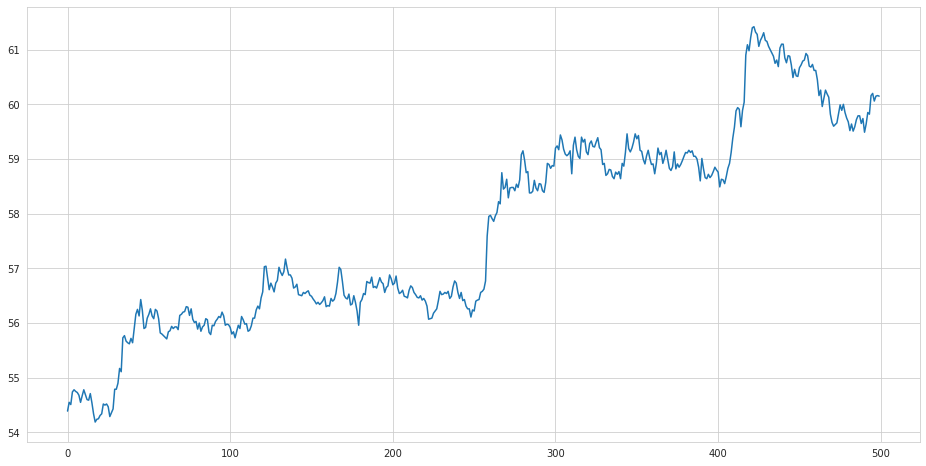

In [17]:
plt.figure(figsize=(16,8))
ltc_test['Close'].iloc[:500].plot()

In [20]:
new_data = client.get_klines(symbol='BTCEUR', 
                              interval=Client.KLINE_INTERVAL_1MINUTE)

In [24]:
test = []
for col in columns:
    test.append(curre+col)

In [25]:
test

['Open Time BTC',
 'Open BTC',
 'High BTC',
 'Low BTC',
 'Close BTC',
 'Volume BTC',
 'Close Time BTC',
 'Quote asset volume BTC',
 'n_trades BTC',
 'Taker buy base asset volume BTC',
 'Taker buy quote asset volume BTC',
 'Ignore BTC']

In [27]:
columns.apply( lambda x: x)

AttributeError: 'list' object has no attribute 'apply'

In [32]:
x = columns.index()

TypeError: index expected at least 1 argument, got 0

[None, None, None, None, None, None, None, None, None, None, None, None]

In [41]:
main_df_cols = []
for col in columns:
    main_df_cols.append('pippo  '+' '+col)

In [42]:
main_df_cols

['pippo   Open Time',
 'pippo   Open',
 'pippo   High',
 'pippo   Low',
 'pippo   Close',
 'pippo   Volume',
 'pippo   Close Time',
 'pippo   Quote asset volume',
 'pippo   n_trades',
 'pippo   Taker buy base asset volume',
 'pippo   Taker buy quote asset volume',
 'pippo   Ignore']